In [12]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling, Normalization


# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
urllib.request.urlretrieve(url, "helper_functions.py")


('helper_functions.py', <http.client.HTTPMessage at 0x234bcac7990>)

In [14]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [15]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [16]:
dataset = r"C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes"
walk_through_dir(dataset)

There are 1 directories and 0 images in 'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes'.
There are 10 directories and 0 images in 'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes'.
There are 0 directories and 1000 images in 'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Bees'.
There are 0 directories and 1000 images in 'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Beetles'.
There are 0 directories and 1000 images in 'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Butterfly'.
There are 0 directories and 1000 images in 'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Cicada'.
There are 0 direct

In [17]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [18]:
from pathlib import Path
import pandas as pd
import os

# Directorio del dataset
image_dir = Path(dataset)

# Obtener los archivos de imagen (sin repetir `png`)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

# Extraer etiquetas a partir de la carpeta padre
labels = [fp.parent.name for fp in filepaths]

# Crear DataFrame
image_df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

# Convertir rutas a string
image_df['Filepath'] = image_df['Filepath'].astype(str)

# Mostrar cantidad de filas
print(f"Total imágenes encontradas: {len(image_df)}")


Total imágenes encontradas: 20000


In [19]:
print(f"Total filas antes de eliminar duplicados: {len(image_df)}")
image_df = image_df.drop_duplicates()
print(f"Total filas después de eliminar duplicados: {len(image_df)}")


Total filas antes de eliminar duplicados: 20000
Total filas después de eliminar duplicados: 10000


In [20]:
image_df

Filepath   Label
0     C:\Users\Pc\workspaceDiseño\proyecto_insectos\...    Bees
1     C:\Users\Pc\workspaceDiseño\proyecto_insectos\...    Bees
2     C:\Users\Pc\workspaceDiseño\proyecto_insectos\...    Bees
3     C:\Users\Pc\workspaceDiseño\proyecto_insectos\...    Bees
4     C:\Users\Pc\workspaceDiseño\proyecto_insectos\...    Bees
...                                                 ...     ...
9995  C:\Users\Pc\workspaceDiseño\proyecto_insectos\...  Spider
9996  C:\Users\Pc\workspaceDiseño\proyecto_insectos\...  Spider
9997  C:\Users\Pc\workspaceDiseño\proyecto_insectos\...  Spider
9998  C:\Users\Pc\workspaceDiseño\proyecto_insectos\...  Spider
9999  C:\Users\Pc\workspaceDiseño\proyecto_insectos\...  Spider

[10000 rows x 2 columns]

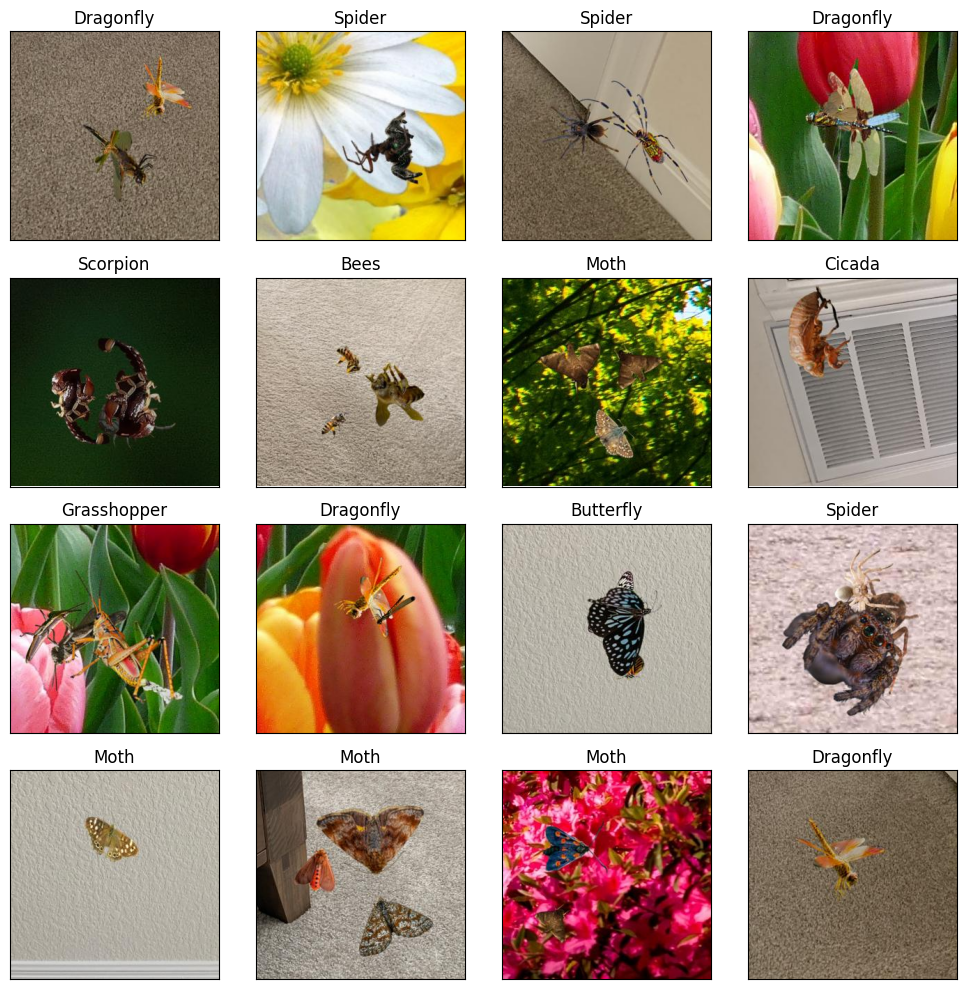

In [21]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [22]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

In [ ]:
# Ruta de la carpeta
image_folder = r'C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Bees'

# Obtener imagen aleatoria
p = random_sample(image_folder)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [ ]:
p = random_sample(image_folder)
print("Imagen seleccionada:", p)

orig = cv2.imread(p)

if orig is None:
    print("Error: OpenCV no pudo cargar la imagen.")
else:
    print("Imagen cargada correctamente.")
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0


In [ ]:
from PIL import Image

try:
    img_pil = Image.open(p)
    img_pil.show()  # Muestra la imagen en el visor de fotos
    print("PIL puede abrir la imagen.")
except Exception as e:
    print("Error con PIL:", e)


In [23]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [24]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [25]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [26]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224, 224),

  layers.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name="data_augmentation")

In [17]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [18]:
# Create checkpoint callback
checkpoint_path = "insect_classification_model_checkpoint.weights.h5"

checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [19]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
import shutil

shutil.rmtree("training_logs", ignore_errors=True)
os.makedirs("training_logs/insect_classification")
print("Carpeta de logs reiniciada.")


In [2]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available: 0
[]


In [4]:
import torch
print("PyTorch CUDA disponible:", torch.cuda.is_available())
print("Número de GPUs:", torch.cuda.device_count())
print("Versión CUDA en PyTorch:", torch.version.cuda)


PyTorch CUDA disponible: False
Número de GPUs: 0
Versión CUDA en PyTorch: None


In [6]:
import tensorflow as tf
print("TensorFlow reconoce GPU:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow reconoce GPU: False


In [20]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        
        checkpoint_callback,
    ]
)

Epoch 1/100


c:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 404ms/step - accuracy: 0.1121 - loss: 2.5651 - val_accuracy: 0.2206 - val_loss: 2.1736
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step - accuracy: 0.1954 - loss: 2.2465 - val_accuracy: 0.3675 - val_loss: 1.9536
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 405ms/step - accuracy: 0.2850 - loss: 2.0332 - val_accuracy: 0.4588 - val_loss: 1.7664
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 407ms/step - accuracy: 0.3719 - loss: 1.8600 - val_accuracy: 0.5419 - val_loss: 1.5971
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 414ms/step - accuracy: 0.4310 - loss: 1.6981 - val_accuracy: 0.5881 - val_loss: 1.4474
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 403ms/step - accuracy: 0.4987 - loss: 1.5736 - val_accuracy: 0.6344 - val_loss: 1.3203
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 414ms/step - accuracy: 0.5279 - loss: 1.4522 - val_accuracy: 0.6575 - val_loss: 1.2115
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 405ms/step - accuracy: 0.5804 - loss: 1.317

In [21]:
from pathlib import Path

# Crear un directorio donde se guardará el modelo
MODELS_DIR = Path("insects-model")
MODELS_DIR.mkdir(parents=True, exist_ok=True)  # Crea el directorio si no existe


In [22]:
# Definir la ruta del modelo
TF_MODEL_PATH = MODELS_DIR.joinpath("model.keras")

# Guardar el modelo completo (arquitectura, pesos y optimizador)
model.save(TF_MODEL_PATH)

In [23]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.46545
Test Accuracy: 84.05%


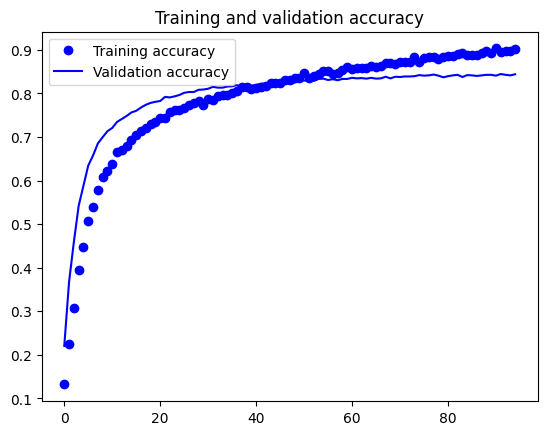

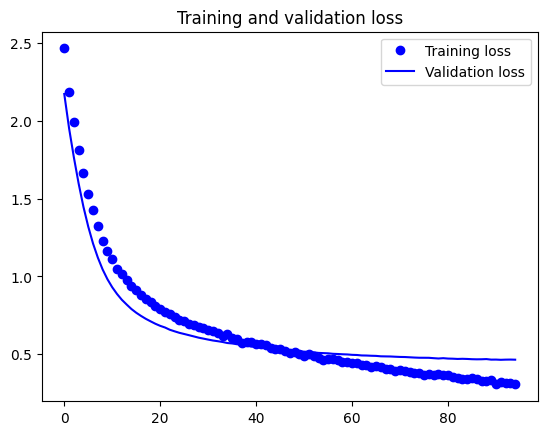

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 383ms/step
The first 5 predictions: ['Dragonfly', 'Cicada', 'Dragonfly', 'Cicada', 'Grasshopper']


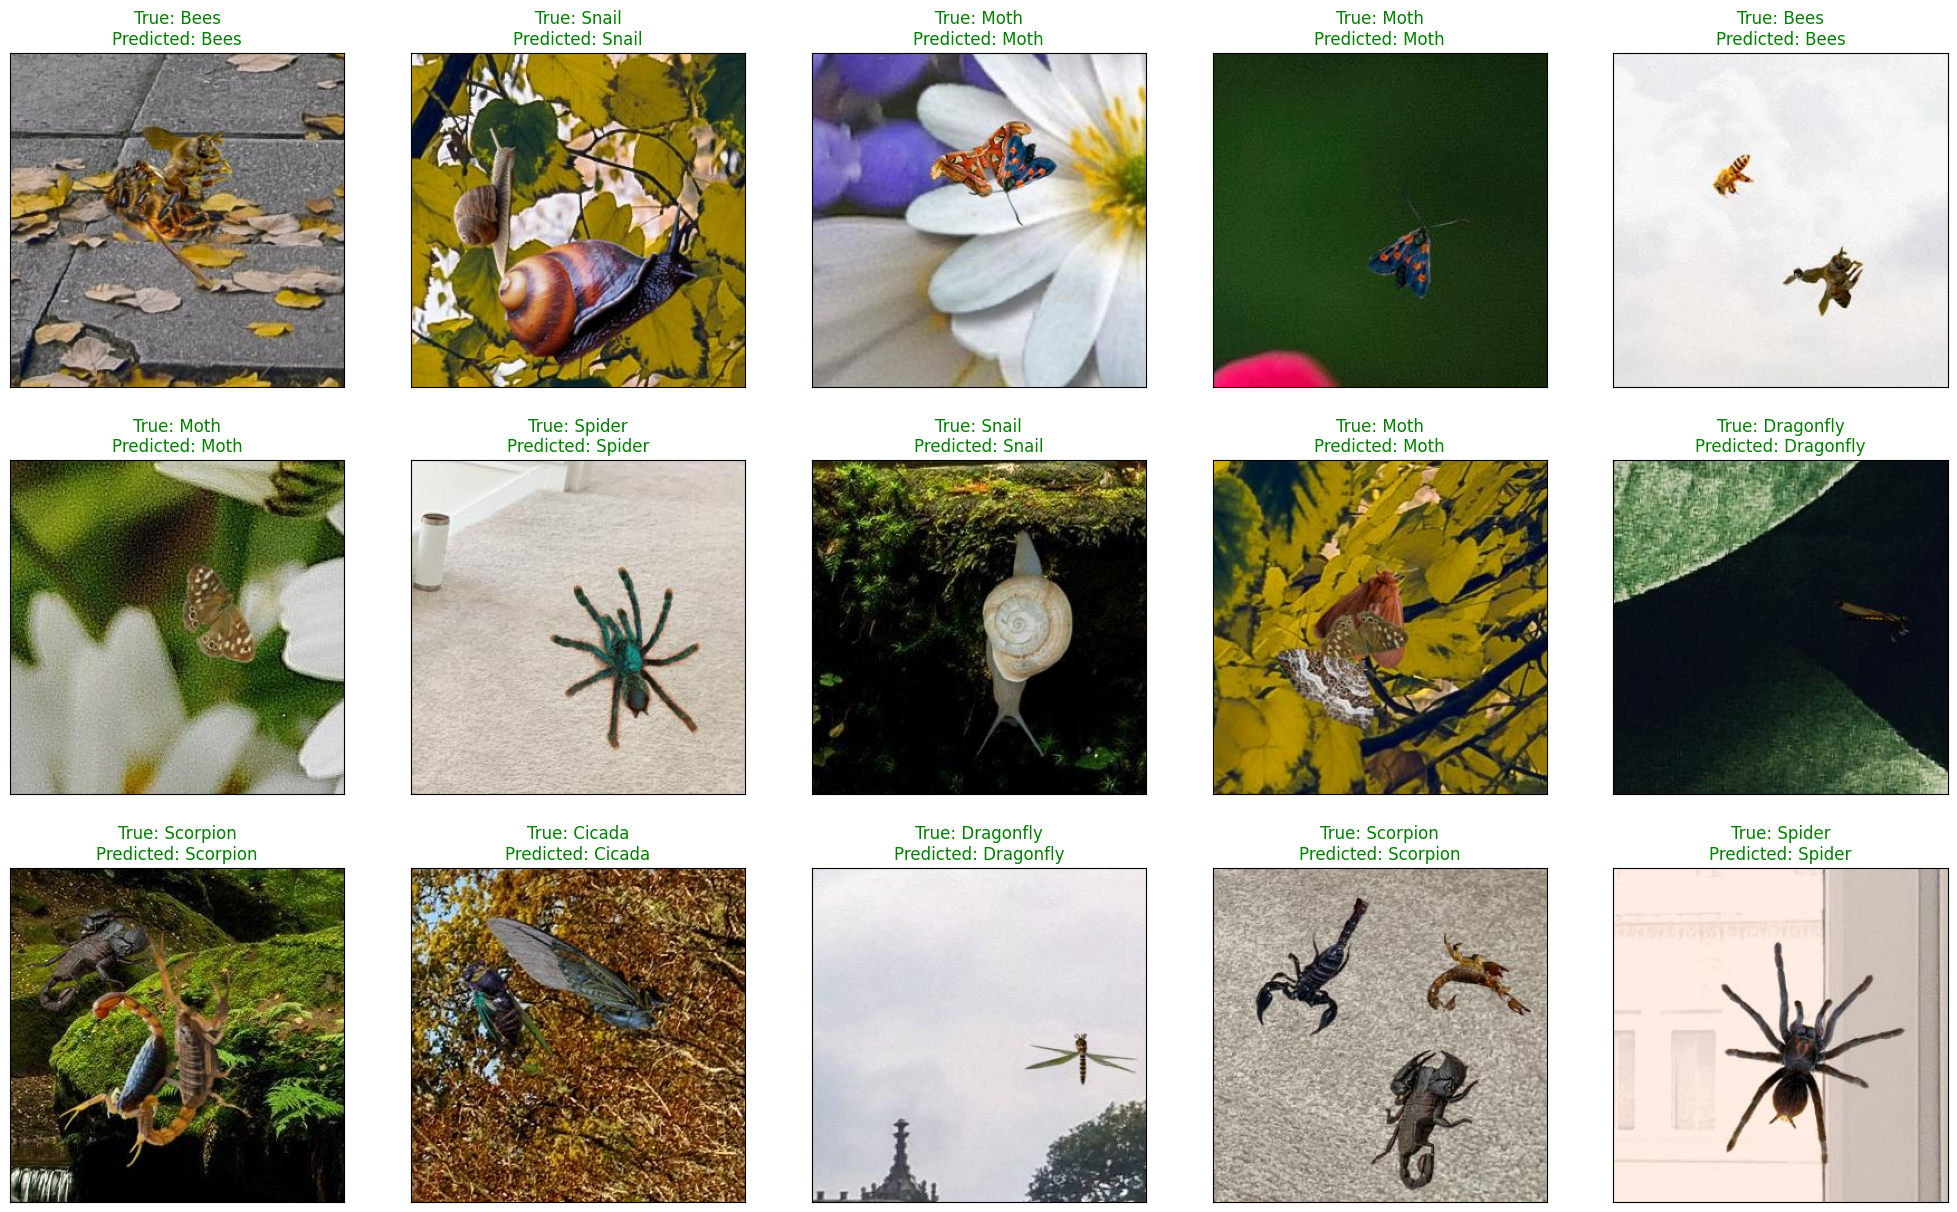

<Figure size 640x480 with 0 Axes>

In [26]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [27]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        Bees       0.76      0.82      0.79       211
     Beetles       0.84      0.82      0.83       205
   Butterfly       0.88      0.84      0.86       208
      Cicada       0.89      0.84      0.86       190
   Dragonfly       0.79      0.80      0.79       207
 Grasshopper       0.77      0.85      0.81       181
        Moth       0.85      0.85      0.85       212
    Scorpion       0.89      0.81      0.85       213
       Snail       0.98      0.99      0.98       184
      Spider       0.78      0.81      0.79       189

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [28]:
print(labels)

{0: 'Bees', 1: 'Beetles', 2: 'Butterfly', 3: 'Cicada', 4: 'Dragonfly', 5: 'Grasshopper', 6: 'Moth', 7: 'Scorpion', 8: 'Snail', 9: 'Spider'}


In [2]:
model = keras.models.load_model(r"C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\insects-model\model.keras")
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,939,488 (15.03 MB)

 Trainable params: 314,378 (1.20 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 628,758 (2.40 MB)

In [3]:
# Genera dos imágenes aleatorias
img1 = np.random.rand(1, 224, 224, 3).astype(np.float32)
img2 = np.random.rand(1, 224, 224, 3).astype(np.float32)

# Predicciones
pred1 = model.predict(img1)
pred2 = model.predict(img2)

# Imprime las predicciones
print("Predicción 1:", pred1)
print("Predicción 2:", pred2)

# Compara si son diferentes
if np.allclose(pred1, pred2):
    print("🚨 El modelo siempre devuelve lo mismo.")
else:
    print("✅ El modelo responde diferente a cada imagen.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicción 1: [[0.42492273 0.12938662 0.09162496 0.01028322 0.05137208 0.02332204
  0.08801502 0.09514549 0.01506639 0.07086142]]
Predicción 2: [[0.42333233 0.12864903 0.09232951 0.01040991 0.05168925 0.0234497
  0.08839019 0.09547405 0.01517094 0.07110509]]
✅ El modelo responde diferente a cada imagen.


In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Cargar imagen
image_path = r"C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\backend\scorp.jpg"
pil_image = Image.open(image_path)
pil_image = pil_image.resize((224, 224))

# Convertir a tensor
image_tensor = tf.convert_to_tensor(np.array(pil_image), dtype=tf.float32)
image_tensor = tf.expand_dims(image_tensor, axis=0)  # Añadir batch dimension
image_tensor = image_tensor / 255.0  # Normalizar

# Verificar valores de la imagen
print("Tamaño imagen:", pil_image.size)
print("Primeros píxeles:", np.array(pil_image)[0][0])
print("Primeros valores normalizados:", image_tensor.numpy()[0][0])

# Hacer la predicción con el modelo entrenado en el notebook
activation_scores = model.predict(image_tensor)

# Si tu modelo usa softmax en la última capa, ya no necesitas aplicarlo de nuevo
# Pero si NO tiene softmax en la última capa, usa:
predictions = tf.nn.softmax(activation_scores).numpy()

# Etiquetas de clases
labels = [ 'Bees', 'Beetles', 'Butterfly', 'Cicada', 'Dragonfly', 'Grasshopper', 'Moth', 'Scorpion', 'Snail', 'Spider']
output_labels = {label: prob for label, prob in zip(labels, predictions[0])}

# Mostrar resultados
print("Predicciones del modelo:", output_labels)


Tamaño imagen: (224, 224)
Primeros píxeles: [160 136 112]
Primeros valores normalizados: [[0.627451   0.53333336 0.4392157 ]
 [0.7019608  0.6117647  0.49803922]
 [0.53333336 0.44705883 0.33333334]
 [0.52156866 0.43529412 0.34509805]
 [0.68235296 0.5921569  0.5019608 ]
 [0.6156863  0.5254902  0.42352942]
 [0.47843137 0.40784314 0.3019608 ]
 [0.6039216  0.54509807 0.4627451 ]
 [0.5529412  0.5019608  0.42745098]
 [0.5882353  0.5176471  0.43529412]
 [0.6156863  0.5176471  0.42352942]
 [0.57254905 0.49803922 0.40392157]
 [0.49019608 0.43137255 0.3647059 ]
 [0.5019608  0.44313726 0.3764706 ]
 [0.49411765 0.43137255 0.34117648]
 [0.58431375 0.52156866 0.42745098]
 [0.53333336 0.46666667 0.38431373]
 [0.6117647  0.5411765  0.44705883]
 [0.6431373  0.58431375 0.5019608 ]
 [0.5411765  0.49803922 0.43137255]
 [0.6627451  0.6156863  0.54901963]
 [0.7019608  0.6313726  0.54509807]
 [0.70980394 0.6313726  0.5372549 ]
 [0.5882353  0.52156866 0.4392157 ]
 [0.62352943 0.5647059  0.4745098 ]
 [0.6235294

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Cargar imagen
image_path = r"C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Grasshopper\00000000.jpg"

pil_image = Image.open(image_path)
pil_image = pil_image.resize((224, 224))


# Verificar los valores de la imagen
print("Tamaño imagen:", pil_image.size)
print("Primeros píxeles:", np.array(pil_image)[0][0])  
print("Primeros valores normalizados:", image_array[0][0])

# Hacer la predicción directamente con numpy
activation_scores = model.predict(pill_image)

# Aplicar softmax solo si es necesario
predictions = tf.nn.softmax(activation_scores).numpy()

# Etiquetas de clases
labels = ['Bees', 'Beetles', 'Butterfly', 'Cicada', 'Dragonfly', 
          'Grasshopper', 'Moth', 'Scorpion', 'Snail', 'Spider']
output_labels = {label: prob for label, prob in zip(labels, predictions[0])}

# Mostrar resultados
print("Predicciones del modelo:", output_labels)

Tamaño imagen: (224, 224)
Primeros píxeles: [191 187 175]
Primeros valores normalizados: [[0.7490196  0.73333335 0.6862745 ]
 [0.77254903 0.75686276 0.70980394]
 [0.654902   0.6392157  0.5921569 ]
 [0.6392157  0.62352943 0.5764706 ]
 [0.67058825 0.654902   0.60784316]
 [0.64705884 0.6313726  0.58431375]
 [0.68235296 0.6666667  0.61960787]
 [0.7058824  0.6901961  0.6431373 ]
 [0.7019608  0.6862745  0.6392157 ]
 [0.67058825 0.654902   0.60784316]
 [0.6666667  0.6509804  0.6039216 ]
 [0.6901961  0.6745098  0.627451  ]
 [0.6862745  0.67058825 0.62352943]
 [0.6666667  0.6509804  0.6039216 ]
 [0.7176471  0.7019608  0.654902  ]
 [0.7411765  0.7254902  0.6784314 ]
 [0.7176471  0.7019608  0.654902  ]
 [0.6156863  0.6        0.5529412 ]
 [0.6392157  0.62352943 0.5764706 ]
 [0.6627451  0.64705884 0.6       ]
 [0.7019608  0.6862745  0.6392157 ]
 [0.7176471  0.7019608  0.654902  ]
 [0.69803923 0.68235296 0.63529414]
 [0.6745098  0.65882355 0.6117647 ]
 [0.6784314  0.6627451  0.6156863 ]
 [0.6666667

In [28]:
batch = next(iter(test_images))  # Obtener un batch de imágenes
images, labels = batch  # Desempaquetar imágenes y etiquetas

print("Forma de las imágenes:", images.shape)  # Debería ser (batch_size, 224, 224, 3)
print("Tipo de las imágenes:", images.dtype)  # Debe ser float32


Forma de las imágenes: (32, 224, 224, 3)
Tipo de las imágenes: float32


In [29]:
print("Forma de image_tensor:", image_tensor.shape)  
print("Tipo de image_tensor:", image_tensor.dtype)  


Forma de image_tensor: (1, 224, 224, 3)
Tipo de image_tensor: <dtype: 'float32'>


In [30]:
# Imagen con un batch de tamaño 1
image_tensor = np.expand_dims(image_tensor, axis=0)  # Esto hace que la forma sea (1, 224, 224, 3)
pred = model.predict(image_tensor)


ValueError: as_list() is not defined on an unknown TensorShape.

In [31]:
print(model.input_shape)  # Esto te muestra la forma de entrada esperada del modelo


(None, 224, 224, 3)


In [32]:
pred = model.predict(image_tensor[0])  # Pasa solo la imagen sin el batch


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [33]:
print(pred)

[[0.41880935 0.12951593 0.09502501 0.01049677 0.05086503 0.02416372
  0.08999285 0.09436799 0.01561214 0.07115118]]


In [34]:
print("Forma de image_tensor:", image_tensor.shape)  # Debería ser (1, 224, 224, 3)
print("Tipo de image_tensor:", image_tensor.dtype)  # Debería ser float32


Forma de image_tensor: (1, 1, 224, 224, 3)
Tipo de image_tensor: float32


In [38]:
# Asegúrate de que la forma de image_tensor sea (1, 224, 224, 3)
image_tensor = np.squeeze(image_tensor, axis=0)

print("Forma de image_tensor:", image_tensor.shape)  # Esto debería dar (1, 224, 224, 3)
print("Tipo de image_tensor:", image_tensor.dtype)  # float32



Forma de image_tensor: (224, 224, 3)
Tipo de image_tensor: float32


In [39]:
pred = model.predict(image_tensor)  # Pasa el tensor completo con el batch
print(pred)


ValueError: as_list() is not defined on an unknown TensorShape.

In [40]:
# Suponiendo que image_tensor es un tensor de la forma (224, 224, 3)
image_tensor = np.expand_dims(image_tensor, axis=0)  # Esto añade la dimensión del batch: (1, 224, 224, 3)

# Verifica la forma
print("Forma de image_tensor:", image_tensor.shape)  # Debería ser (1, 224, 224, 3)

# Realiza la predicción
pred = model.predict(image_tensor)
print(pred)


Forma de image_tensor: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[[0.41880935 0.12951593 0.09502501 0.01049677 0.05086503 0.02416372
  0.08999285 0.09436799 0.01561214 0.07115118]]


In [42]:
import numpy as np
from PIL import Image
import tensorflow as tf

# Ruta de la imagen que estamos probando
image_path = r"C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Grasshopper\00000000.jpg"

# Cargar y redimensionar la imagen
image = Image.open(image_path)
image = image.resize((224, 224))

# Convertir la imagen a un array de numpy y normalizar
image_array = np.array(image, dtype=np.float32) / 255.0  # Normalizar a rango [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Añadir la dimensión de batch (1, 224, 224, 3)

# Verificar el tamaño y tipo de la imagen
print(f"Tamaño de la imagen: {image_array.shape}")
print(f"Tipo de la imagen: {image_array.dtype}")

# Hacer la predicción
pred = model.predict(image_array)

# Aplicar softmax si es necesario
predictions = tf.nn.softmax(pred).numpy()

# Mapeo de clases
labels = ['Bees', 'Beetles', 'Butterfly', 'Cicada', 'Dragonfly', 
          'Grasshopper', 'Moth', 'Scorpion', 'Snail', 'Spider']

# Mostrar las predicciones
output_labels = {label: prob for label, prob in zip(labels, predictions[0])}
print("Predicciones del modelo:", output_labels)

# Mostrar la etiqueta con la mayor probabilidad
predicted_class = np.argmax(predictions, axis=1)
print(f"La clase predicha es: {labels[predicted_class[0]]}")


Tamaño de la imagen: (1, 224, 224, 3)
Tipo de la imagen: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicciones del modelo: {'Bees': np.float32(0.13792887), 'Beetles': np.float32(0.10190504), 'Butterfly': np.float32(0.098428234), 'Cicada': np.float32(0.09080441), 'Dragonfly': np.float32(0.09438417), 'Grasshopper': np.float32(0.091919325), 'Moth': np.float32(0.09808881), 'Scorpion': np.float32(0.09884939), 'Snail': np.float32(0.091152035), 'Spider': np.float32(0.09653969)}
La clase predicha es: Bees


In [43]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Ruta de la imagen que estamos probando
image_path = r"C:\Users\Pc\workspaceDiseño\proyecto_insectos\project-template\models\dataset\archive\Insect_Classes\Insect_Classes\Grasshopper\00000000.jpg"

# Cargar y redimensionar la imagen
image = Image.open(image_path)
image = image.resize((224, 224))

# Convertir la imagen a un array de numpy
image_array = np.array(image, dtype=np.float32)

# Aplicar preprocesamiento de MobileNetV3 (igual que en el entrenamiento)
image_array = preprocess_input(image_array)  # Normaliza la imagen de la misma manera que en el entrenamiento

# Añadir la dimensión de batch (1, 224, 224, 3)
image_array = np.expand_dims(image_array, axis=0)

# Verificar el tamaño y tipo de la imagen
print(f"Tamaño de la imagen: {image_array.shape}")
print(f"Tipo de la imagen: {image_array.dtype}")

# Hacer la predicción
pred = model.predict(image_array)

# Aplicar softmax si es necesario
predictions = tf.nn.softmax(pred).numpy()

# Mapeo de clases
labels = ['Bees', 'Beetles', 'Butterfly', 'Cicada', 'Dragonfly', 
          'Grasshopper', 'Moth', 'Scorpion', 'Snail', 'Spider']

# Mostrar las predicciones
output_labels = {label: prob for label, prob in zip(labels, predictions[0])}
print("Predicciones del modelo:", output_labels)

# Mostrar la etiqueta con la mayor probabilidad
predicted_class = np.argmax(predictions, axis=1)
print(f"La clase predicha es: {labels[predicted_class[0]]}")


Tamaño de la imagen: (1, 224, 224, 3)
Tipo de la imagen: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicciones del modelo: {'Bees': np.float32(0.08534714), 'Beetles': np.float32(0.08534768), 'Butterfly': np.float32(0.08534719), 'Cicada': np.float32(0.08535456), 'Dragonfly': np.float32(0.085407935), 'Grasshopper': np.float32(0.23180465), 'Moth': np.float32(0.08534913), 'Scorpion': np.float32(0.08534718), 'Snail': np.float32(0.085347146), 'Spider': np.float32(0.08534732)}
La clase predicha es: Grasshopper
